[INFO] Streaming PGN and collecting unique users...
[INFO] 100000 games processed, 56506 unique users collected...
[INFO] 200000 games processed, 93290 unique users collected...
[INFO] Target unique users reached.
[INFO] Finished. Games processed: 282662, Unique users collected: 123456


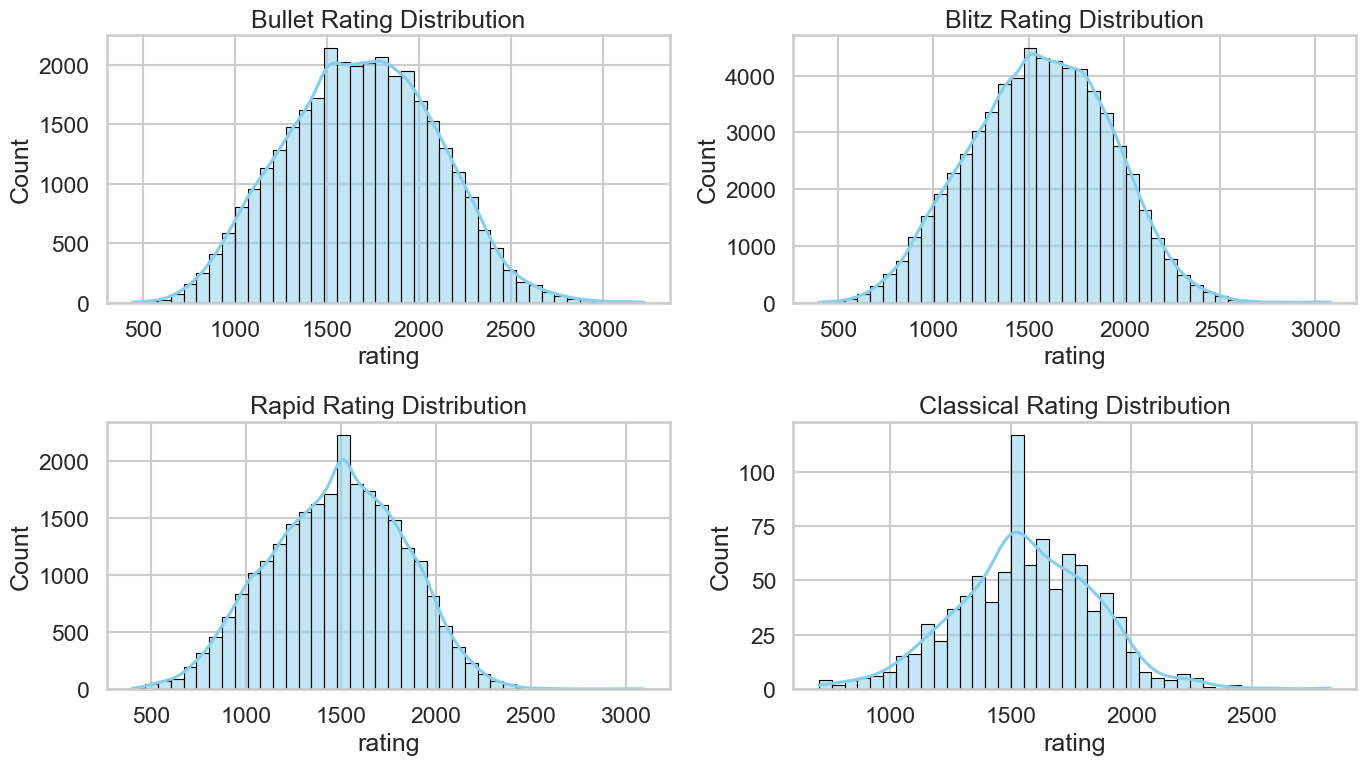

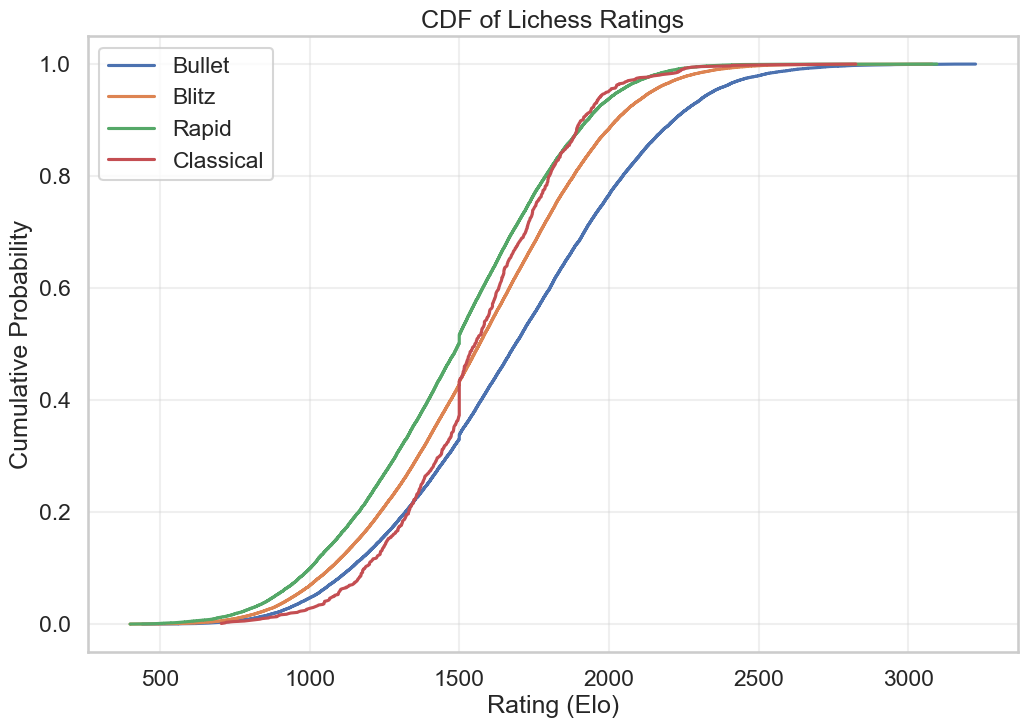


[INFO] Lichess summary statistics and normality tests:
   time_control     mean     std  skew  kurtosis  KS_p  Shapiro_p
0       bullet  1686.04  410.29  0.04     -0.35  0.00       0.00
1        blitz  1560.45  364.63 -0.04     -0.33  0.00       0.00
2        rapid  1476.68  351.67 -0.10     -0.35  0.00       0.00
3    classical  1562.16  286.33  0.00      0.46  0.05       0.01


C:\Users\joshu\AppData\Local\Temp\ipykernel_5560\676659586.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="time_control", y="rating", data=df_users, palette="Pastel2")


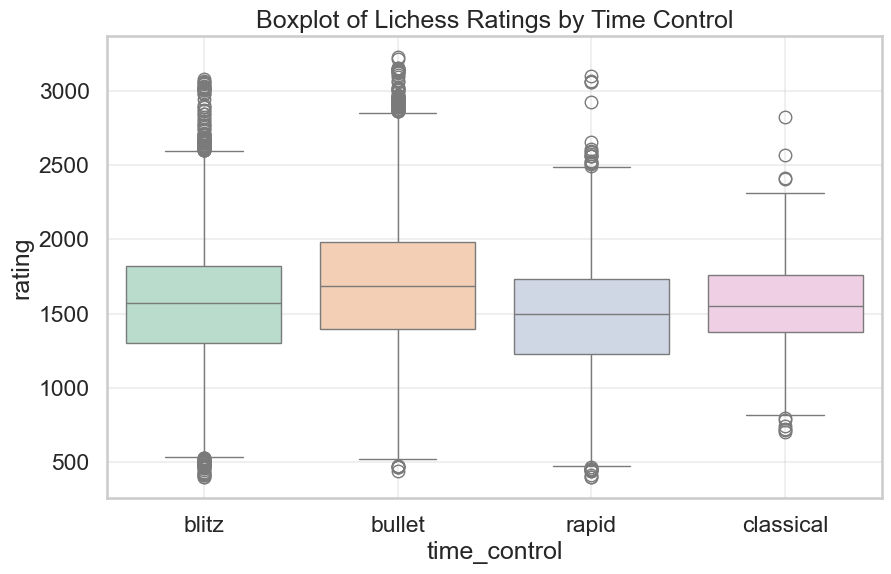

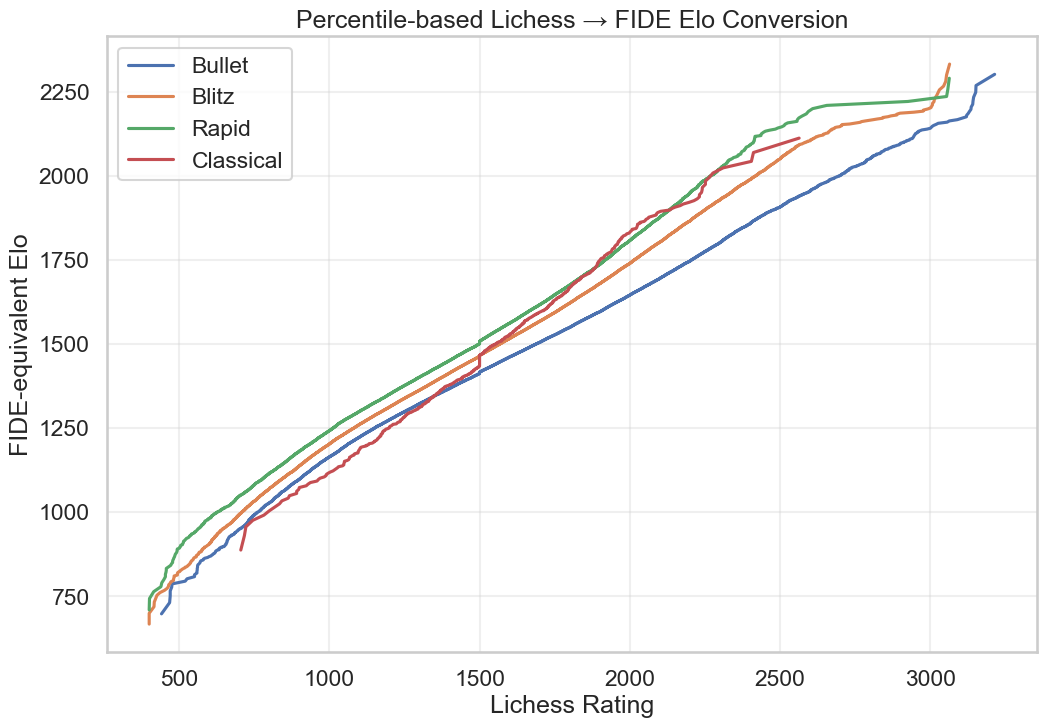


✅ Completed Lichess and FIDE percentile mapping.


In [1]:
# ======================================================
# Lichess + FIDE Ratings Analysis + Percentile Mapping
# ======================================================
import requests
import zstandard as zstd
import chess.pgn
from io import TextIOWrapper, BytesIO
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy import stats
import zipfile

# ===============================
# PARAMETERS
# ===============================
ZST_URL = "https://database.lichess.org/standard/lichess_db_standard_rated_2025-09.pgn.zst"
TARGET_GAMES = 321654
TARGET_UNIQUE_USERS = 123456
EXPORT_DIR = "lichess_ratings_by_timecontrol"
FIDE_ZIP_URL = "http://ratings.fide.com/download/players_list.zip"
percentiles = [0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99]

# ===============================
# UTILITY FUNCTIONS
# ===============================
def classify_time_control(tc):
    try:
        if "+" in tc:
            base, inc = tc.split("+")
            base = int(base)
        else:
            base = int(tc)
        if base < 180:       return "bullet"
        elif base < 600:     return "blitz"
        elif base < 1800:    return "rapid"
        else:                return "classical"
    except:
        return None

# ===============================
# STREAM LICHESS PGN
# ===============================
print("[INFO] Streaming PGN and collecting unique users...")
unique_users = {}
time_control_labels = ["bullet","blitz","rapid","classical"]

with requests.get(ZST_URL, stream=True) as r:
    r.raise_for_status()
    dctx = zstd.ZstdDecompressor()
    with dctx.stream_reader(r.raw) as reader:
        text_stream = TextIOWrapper(reader, encoding='utf-8', errors='ignore')
        game_count = 0
        for _ in range(TARGET_GAMES):
            game = chess.pgn.read_game(text_stream)
            if game is None:
                break
            h = game.headers
            white, black = h.get("White",""), h.get("Black","")
            try:
                wr, br = int(h.get("WhiteElo",0)), int(h.get("BlackElo",0))
            except:
                continue
            if not (white and black and wr and br):
                continue
            tc_category = classify_time_control(h.get("TimeControl",""))
            if tc_category is None:
                continue
            if white not in unique_users and len(unique_users)<TARGET_UNIQUE_USERS:
                unique_users[white] = {"rating":wr,"time_control":tc_category}
            if black not in unique_users and len(unique_users)<TARGET_UNIQUE_USERS:
                unique_users[black] = {"rating":br,"time_control":tc_category}
            game_count += 1
            if game_count % 100_000 == 0:
                print(f"[INFO] {game_count} games processed, {len(unique_users)} unique users collected...")
            if len(unique_users)>=TARGET_UNIQUE_USERS:
                print("[INFO] Target unique users reached.")
                break

print(f"[INFO] Finished. Games processed: {game_count}, Unique users collected: {len(unique_users)}")

# ===============================
# CREATE DATAFRAME
# ===============================
df_users = pd.DataFrame([{"player":u,"rating":d["rating"],"time_control":d["time_control"]} 
                         for u,d in unique_users.items()])
os.makedirs(EXPORT_DIR, exist_ok=True)
for tc in time_control_labels:
    subset = df_users[df_users["time_control"]==tc]
    if subset.empty: continue
    subset.to_csv(os.path.join(EXPORT_DIR,f"{tc}_ratings.csv"), index=False)

# ===============================
# PLOT DISTRIBUTIONS
# ===============================
sns.set(style="whitegrid", context="talk")
plt.figure(figsize=(14,8))
for i, tc in enumerate(time_control_labels):
    subset = df_users[df_users["time_control"]==tc]
    if subset.empty: continue
    plt.subplot(2,2,i+1)
    sns.histplot(subset["rating"], bins=40, kde=True, color="skyblue", edgecolor="black")
    plt.title(f"{tc.capitalize()} Rating Distribution")
plt.tight_layout()
plt.show()

# ===============================
# CDFs and Normality Tests
# ===============================
plt.figure(figsize=(12,8))
results=[]
cdf_data = {}
for tc in time_control_labels:
    subset = df_users[df_users["time_control"]==tc]["rating"]
    if subset.empty: continue
    sorted_vals = np.sort(subset)
    yvals = np.arange(1,len(sorted_vals)+1)/len(sorted_vals)
    plt.plot(sorted_vals, yvals, label=tc.capitalize())
    cdf_data[tc] = {"ratings": sorted_vals, "cdf": yvals}
    
    mean,std = np.mean(subset), np.std(subset)
    skew = stats.skew(subset)
    kurt = stats.kurtosis(subset)
    ks_stat, ks_p = stats.kstest((subset-mean)/std, "norm")
    shapiro_stat, shapiro_p = stats.shapiro(subset[:5000])
    results.append({"time_control":tc,"mean":mean,"std":std,"skew":skew,
                    "kurtosis":kurt,"KS_p":ks_p,"Shapiro_p":shapiro_p})
plt.title("CDF of Lichess Ratings")
plt.xlabel("Rating (Elo)"); plt.ylabel("Cumulative Probability")
plt.grid(True,alpha=0.3); plt.legend(); plt.show()

results_df = pd.DataFrame(results)
print("\n[INFO] Lichess summary statistics and normality tests:\n", results_df.round(2))

# ===============================
# BOXPLOTS
# ===============================
plt.figure(figsize=(10,6))
sns.boxplot(x="time_control", y="rating", data=df_users, palette="Pastel2")
plt.title("Boxplot of Lichess Ratings by Time Control")
plt.grid(True,alpha=0.3); plt.show()

# ===============================
# PERCENTILE-BASED LICHESS → FIDE MAPPING
# ===============================
fide_mapping = {}
fide_mean, fide_std = 1500, 200
for tc, data in cdf_data.items():
    cdf_vals = data["cdf"]
    fide_equiv = stats.norm.ppf(cdf_vals, loc=fide_mean, scale=fide_std)
    fide_mapping[tc] = {"lichess": data["ratings"], "fide_equiv": fide_equiv}

plt.figure(figsize=(12,8))
for tc, mapping in fide_mapping.items():
    plt.plot(mapping["lichess"], mapping["fide_equiv"], label=tc.capitalize())
plt.title("Percentile-based Lichess → FIDE Elo Conversion")
plt.xlabel("Lichess Rating"); plt.ylabel("FIDE-equivalent Elo")
plt.grid(True, alpha=0.3); plt.legend(); plt.show()

print("\n✅ Completed Lichess and FIDE percentile mapping.")





# Push files to Repo

* In cases where you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [4]:


# Safe Recursive Git Auto-Push for Jupyter Notebooks
# Skips notebooks with unresolved Git conflicts


import json
import subprocess
import hashlib
from pathlib import Path
from IPython.display import Javascript, display
import ipynbname
import datetime

def run_cmd(cmd, check=True, capture_output=False):
    """Run a shell command safely."""
    try:
        result = subprocess.run(cmd, check=check, capture_output=capture_output, text=True)
        if capture_output:
            return result.stdout.strip()
    except subprocess.CalledProcessError as e:
        if capture_output:
            print(f"[ERROR] Command failed: {' '.join(cmd)}\n{e.stderr}")
        raise

def file_hash(path):
    """Compute MD5 hash of a file."""
    with open(path, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

def is_valid_notebook(path):
    """Return True if the notebook is valid JSON and has no Git conflict markers."""
    try:
        with open(path, "r", encoding="utf-8") as f:
            content = f.read()
            if "<<<<<<<" in content or ">>>>>>>" in content or "=======" in content:
                print(f"[WARN] Skipping {path} — contains Git conflict markers")
                return False
            json.loads(content)
        return True
    except json.JSONDecodeError:
        print(f"[WARN] Skipping {path} — invalid JSON")
        return False

# --------------------------
# 1️⃣ Save current notebook
# --------------------------
display(Javascript('IPython.notebook.save_checkpoint();'))
print("[INFO] Notebook checkpoint saved.")

# --------------------------
# 2️⃣ Detect project root
# --------------------------
try:
    notebook_path = ipynbname.path()
except Exception:
    raise RuntimeError("[ERROR] Cannot detect notebook path. Save and retry.")

project_root = Path(notebook_path).parents[1]  # adjust if your notebooks are deeper
print(f"[INFO] Using project root folder: {project_root}")

# --------------------------
# 3️⃣ Find all valid notebooks recursively
# --------------------------
all_notebooks = list(project_root.rglob("*.ipynb"))
valid_notebooks = [nb for nb in all_notebooks if is_valid_notebook(nb)]

if not valid_notebooks:
    print("[INFO] No valid notebooks to commit.")
else:
    print(f"[INFO] Found {len(valid_notebooks)} valid notebook(s).")

# --------------------------
# 4️⃣ Apply dummy update and commit modified notebooks
# --------------------------
modified_notebooks = []

for nb_path in valid_notebooks:
    old_hash = file_hash(nb_path)
    with open(nb_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    # Add a Markdown timestamp cell
    dummy_cell = {
        "cell_type": "markdown",
        "metadata": {},
        "source": [f"Auto-update: {datetime.datetime.now().isoformat()}\n"]
    }
    data["cells"].append(dummy_cell)

    with open(nb_path, "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=1)

    new_hash = file_hash(nb_path)
    if new_hash != old_hash:
        modified_notebooks.append(nb_path)

if modified_notebooks:
    for nb in modified_notebooks:
        run_cmd(["git", "add", "-f", str(nb)])
    commit_msg = f"Auto-update {len(modified_notebooks)} notebook(s)"
    result = subprocess.run(["git", "commit", "-m", commit_msg],
                            capture_output=True, text=True)
    print(f"[INFO] {result.stdout.strip().splitlines()[-1]}")
else:
    print("[INFO] No notebooks changed. Nothing to commit.")

# --------------------------
# 5️⃣ Detect current branch
# --------------------------
branch = run_cmd(["git", "branch", "--show-current"], capture_output=True) or "main"
print(f"[INFO] Current Git branch: {branch}")

# --------------------------
# 6️⃣ Push to GitHub
# --------------------------
try:
    run_cmd(["git", "push", "origin", branch])
    print(f"[SUCCESS] Pushed to GitHub branch: {branch}")
    print(f"🌐 View updates: https://github.com/JoshuaTutin/Capstone-Project/commits/{branch}")
except subprocess.CalledProcessError:
    print("[ERROR] Git push failed!")
    print("⚙️ Fix this by running manual push once with a Personal Access Token (PAT):")
    print("1️⃣ Ensure remote URL: git remote -v")
    print("2️⃣ Configure Git to store credentials: git config --global credential.helper store")
    print("3️⃣ Push manually: git push origin main (enter username + PAT)")








<IPython.core.display.Javascript object>

[INFO] Notebook checkpoint saved.
[INFO] Using project root folder: c:\Users\joshu\OneDrive\Desktop\Coding projects\Capstone project\Capstone-Project
[WARN] Skipping c:\Users\joshu\OneDrive\Desktop\Coding projects\Capstone project\Capstone-Project\jupyter_notebooks\Notebook_Template.ipynb — contains Git conflict markers
[INFO] No valid notebooks to commit.
[INFO] No notebooks changed. Nothing to commit.
[INFO] Current Git branch: main
[ERROR] Git push failed!
⚙️ Fix this by running manual push once with a Personal Access Token (PAT):
1️⃣ Ensure remote URL: git remote -v
2️⃣ Configure Git to store credentials: git config --global credential.helper store
3️⃣ Push manually: git push origin main (enter username + PAT)
